In [1]:
import torch
import numpy as np
import scipy as sc
from torchvision import transforms, datasets
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

In [8]:
# Input
import torchaudio
sound, sample_rate = torchaudio.load('./dataset/audios/s1_u1.wav')

sound_avg = sound.mean(1)
audio_len = sound_avg.size()[0]
sample_window = 8000
overlapping = 2000
left = 0
right = 8000
audio_data = torch.Tensor()
while left < audio_len:
    sample = sound_avg[left:right]
    if sample.size()[0] != 8000:
        break
    sample = sample.view(1, 1, sample.size()[0])
    audio_data = torch.cat((audio_data, sample))
#     print(audio_data.size())
#     print(sample.size())
    left = right - overlapping
    right = left + sample_window


    
print(audio_data.size())
sound_inp = sound_avg.view(1, 1, sound_avg.size()[0])
# overlappig = 2000

torch.Size([38, 1, 8000])


In [177]:
# Context Encoder

class Conv1DAudio(nn.Module):
    def __init__(self, in_ch, out_ch, kernel, stride, padding):
        super(Conv1DAudio, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=in_ch, out_channels=out_ch, kernel_size=kernel, stride=stride, padding=padding),
            nn.BatchNorm1d(out_ch),
            nn.ReLU()
        )

    def forward(self, x):
        out = self.conv(x)
        return out

class AudioEncoder(nn.Module):
    def __init__(self):
        super(AudioEncoder, self).__init__()
        self.a_c_1 = Conv1DAudio(1, 16, 250, 50, 100)
        self.a_c_2 = Conv1DAudio(16, 32, 4, 2, 1)
        self.a_c_3 = Conv1DAudio(32, 64, 4, 2, 1)
        self.a_c_4 = Conv1DAudio(64, 128, 4, 2, 1)
        self.a_c_5 = Conv1DAudio(128, 256, 4, 2, 1)
        self.a_c_6 = Conv1DAudio(256, 512, 4, 2, 1)
        self.fc1 = nn.Linear(5*512, 256)

    def forward(self, x):
        ac1 = self.a_c_1(x)    
        ac2 = self.a_c_2(ac1)
        ac3 = self.a_c_3(ac2)
        ac4 = self.a_c_4(ac3)
        ac5 = self.a_c_5(ac4)
        ac6 = self.a_c_6(ac5)
        ac6 = ac6.view(-1, 5*512)
        audio_encoding = self.fc1(ac6)
        return audio_encoding

# audio_encoder = AudioEncoder()
# encoded = audio_encoder(data)


audio_enc = AudioEncoder()
out = audio_enc(audio_data)
out = out.view(out.size()[0], 1, out.size()[1])
print(out.size())

SEQ_LEN = 1
AUDIO_OUTPUT = 256
BATCH = 100
HIDDEN_SIZE_AUDIO = 256
NUM_LAYERS_AUDIO = 2

# input = torch.randn(SEQ_LEN, BATCH, AUDIO_OUTPUT)
rnn = nn.GRU(AUDIO_OUTPUT, HIDDEN_SIZE_AUDIO, NUM_LAYERS_AUDIO)
output, hn = rnn(out)
output.size()


torch.Size([38, 1, 256])


torch.Size([38, 1, 256])

In [201]:
# Noise Encoder

SEQ_LEN = 1
NOISE_OUTPUT = 10
BATCH = 38
HIDDEN_SIZE_NOISE = 10
NUM_LAYERS_NOISE = 1
noise = torch.rand(BATCH, 1, NOISE_OUTPUT)
noise = Variable(noise)
noise = noise.data.resize_(noise.size()).normal_(0, 0.6)
rnn = nn.GRU(NOISE_OUTPUT, HIDDEN_SIZE_NOISE, NUM_LAYERS_NOISE)
output_noise, hn_noise = rnn(noise)

torch.Size([38, 1, 10])

In [9]:
# Identity Encoder and Frame Decoder

class Down(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_x, kernel_y, stride, padding):
        super(Down, self).__init__()
        self.conv = nn.Sequential(
        nn.Conv2d(
            in_channels=in_ch,
            out_channels=out_ch,
            kernel_size=(kernel_x, kernel_y),
            stride=stride,
            padding=padding),
        nn.ReLU()
        )

    def forward(self, x):
        out = self.conv(x)
        return out
    

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, d_k_x, d_k_y, s_d, c_k_x, c_k_y, s_c, padding):
        super(Up, self).__init__()

        self.deconv = nn.Sequential(
        nn.ConvTranspose2d(
            in_channels=in_ch,
            out_channels=out_ch,
            kernel_size=(d_k_x, d_k_y),
            stride=s_d
            ),
            nn.ReLU()
        )
        self.conv = nn.Sequential(
        nn.Conv2d(
            in_channels=2*out_ch,
            out_channels=out_ch,
            kernel_size=(c_k_x, c_k_y),
            stride=s_c,
            padding=padding
            ),
            nn.ReLU()
        )

    def forward(self, x1, x2):
        print("x1 size ", x1.size())
        print("x2 size ", x2.size())
        x1 = self.deconv(x1)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
                        diffY // 2, int(diffY / 2)))
        print("x1 after deconv size ", x1.size())
        print("x2 after pad size ", x2.size())
        x = torch.cat([x2, x1], dim=1)

#         x = torch.add(x1, x2)
        print("x size ", x.size())
        x = self.conv(x)
        return x



class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        
        # Identity Encoder 
        
        self.i_c_1 = Down(3, 64, 4, 4, 2, 1)
        self.i_c_2 = Down(64, 128, 4, 4, 2, 1)
        self.i_c_3 = Down(128, 256, 4, 4, 2, 1)
        self.i_c_4 = Down(256, 512, 4, 4, 2, 1)
        self.i_c_5 = Down(512, 1024, 4, 4, 2, 1)
        self.i_c_6 = Down(1024, 50, 3, 3, 2, 1)
        
        # Frame decoder
        
        self.f_d_1 = Up(50, 1024, 4, 4, 1, 3, 3, 2, 1)
        self.f_d_2 = Up(1024, 512, 4, 4, 2, 3, 3, 1, 1)
        self.f_d_3 = Up(512, 256, 4, 4, 2, 3, 3, 1, 4)
        self.f_d_4 = Up(256, 128, 4, 4, 2, 3, 3, 1, 4)
        
        self.f_d_5 = nn.Sequential(
        nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64, 
            kernel_size=(3,3),
            stride=1,
            padding=5,
            ),
            nn.ReLU()
        )
        
        self.f_d_6 = nn.Sequential(
        nn.ConvTranspose2d(
            in_channels=64,
            out_channels=3, 
            kernel_size=(3,3),
            stride=2,
            padding=1
            ),
            nn.ReLU()
        )
                
        
    def forward(self, x):
        i_64 = self.i_c_1(x)
        print(i_64.size())
        i_128 = self.i_c_2(i_64)
        print(i_128.size())
        i_256 = self.i_c_3(i_128)
        print(i_256.size())
        i_512 = self.i_c_4(i_256)
        print(i_512.size())
        i_1024 = self.i_c_5(i_512)
        print(i_1024.size())
        
        # concatenate noise and audio
        latent = self.i_c_6(i_1024)
        print(latent.size())
        print("---------------------")
        f_1024 = self.f_d_1(latent, i_1024)
        print('f 1024 ', f_1024.size())
        f_512 = self.f_d_2(f_1024, i_512)
        print('f 512 ', f_512.size())
        f_256 = self.f_d_3(f_512, i_256)
        print('f 256 ', f_256.size())
        f_128 = self.f_d_4(f_256, i_128)
        print('f 128 ', f_128.size())
        f_64 = self.f_d_5(f_128)
        print('f 64 ', f_64.size())
        f_3 = self.f_d_6(f_64)
        print('f 3 ', f_3.size())
        return f_3

In [10]:
data_transform = {
        'frames': transforms.Compose([
            transforms.Resize(96),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }

frames = datasets.ImageFolder('./dataset/', data_transform['frames'])
dset_loader = torch.utils.data.DataLoader(frames, batch_size=1, shuffle=False, num_workers=4)
model = Unet()
# out = model()
for data in dset_loader:
    inputs, _ = data
print(inputs.size())
image = torch.rand(1, 3, 96, 96)
out = model(inputs)

torch.Size([1, 3, 96, 96])
torch.Size([1, 64, 48, 48])
torch.Size([1, 128, 24, 24])
torch.Size([1, 256, 12, 12])
torch.Size([1, 512, 6, 6])
torch.Size([1, 1024, 3, 3])
torch.Size([1, 50, 2, 2])
---------------------
x1 size  torch.Size([1, 50, 2, 2])
x2 size  torch.Size([1, 1024, 3, 3])
x1 after deconv size  torch.Size([1, 1024, 5, 5])
x2 after pad size  torch.Size([1, 1024, 5, 5])
x size  torch.Size([1, 2048, 5, 5])
f 1024  torch.Size([1, 1024, 3, 3])
x1 size  torch.Size([1, 1024, 3, 3])
x2 size  torch.Size([1, 512, 6, 6])
x1 after deconv size  torch.Size([1, 512, 8, 8])
x2 after pad size  torch.Size([1, 512, 8, 8])
x size  torch.Size([1, 1024, 8, 8])
f 512  torch.Size([1, 512, 8, 8])
x1 size  torch.Size([1, 512, 8, 8])
x2 size  torch.Size([1, 256, 12, 12])
x1 after deconv size  torch.Size([1, 256, 18, 18])
x2 after pad size  torch.Size([1, 256, 18, 18])
x size  torch.Size([1, 512, 18, 18])
f 256  torch.Size([1, 256, 24, 24])
x1 size  torch.Size([1, 256, 24, 24])
x2 size  torch.Size([

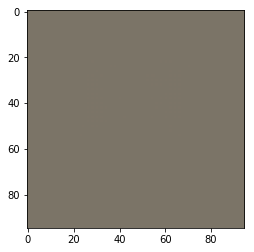

In [206]:
import matplotlib.pyplot as plt
def visualize_image(inp):
    """
        See a particular image
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
#     plt.show()
    
visualize_image(inputs[0])
# # inputs[0].size()
# print(inputs.size())
# print(type(out[0].detach().numpy()))
visualize_image(out[0].detach())

In [50]:
out.size()

torch.Size([1, 3, 57, 57])

In [198]:
# Discriminator Models

class Convolution(nn.Module):
    def __init__(self, in_ch, out_ch, kernel, stride):
        super(Convolution, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=in_ch, 
                out_channels=out_ch, 
                kernel_size=kernel, 
                stride=stride), 
            nn.ReLU()
        )
    
    def forward(self, x):
        out = self.conv(x)
        return out

class FrameDiscriminator(nn.Module):
    def __init__(self):
        super(FrameDiscriminator, self).__init__()
        
        self.c1 = Convolution(3, 64, 4, 2)
        self.c2 = Convolution(64, 128, 4, 2)
        self.c3 = Convolution(128, 256, 4, 2)
        self.c4 = Convolution(256, 512, 4, 2)
        self.c5 = Convolution(512, 1024, 4, 2)
        self.c6 = nn.Linear(1024*4*4, 128)
        self.c7 = nn.Linear(128, 2)
        
    def forward(self, x):
        x = self.c1(x)
        x = self.c2(x)
        x = self.c3(x)
        x = self.c4(x)
        x = self.c5(x)
        x = x.view(-1, 1024*4*4)
        x = self.c6(x)
        out = self.c7(x)
        out = F.sigmoid(out)
        return out

class ImageEncoder(nn.Module):
    def __init__(self):
        super(ImageEncoder, self).__init__()
        self.i_c_1 = Convolution(3, 64, 3, 2)
        self.i_c_2 = Convolution(64, 128, 3, 2)
        self.i_c_3 = Convolution(128, 256, 3, 2)
        self.i_c_4 = Convolution(256, 512, 3, 2)
#         self.i_c_5 = Convolution(512, 1024, 4, 2)
        self.i_c_5 = Convolution(512, 256, 3, 1)
        self.i_c_6 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, 
                out_channels=50, 
                kernel_size=(3,3), 
                stride=2), 
            nn.ReLU()
        )
        
    def forward(self, x):

        i_64 = self.i_c_1(x)
        print(i_64.size())
        i_128 = self.i_c_2(i_64)
        print(i_128.size())
        i_256 = self.i_c_3(i_128)
        print(i_256.size())
        i_512 = self.i_c_4(i_256)
        print(i_512.size())
        i_1024 = self.i_c_5(i_512)
        print(i_1024.size())
        latent = self.i_c_6(i_1024) 
        return latent


class SequenceDiscriminator(nn.Module):
    def __init__(self):
        super(SequenceDiscriminator, self).__init__()
        self.audio_encoder = AudioEncoder()
        self.image_encoder = ImageEncoder()
        self.gru_image = nn.GRU(50, 50, 2)
        self.gru_audio = nn.GRU(256, 256, 2)
        self.fc1 = nn.Linear(306, 64)
        self.fc2 = nn.Linear(64, 2)
        
    def forward(self, i_i, i_a):
        o_i = self.image_encoder(i_i)
        print("o_i ", o_i.size())
        o_i = o_i.view(1, 1, 50)
        o_i, h_n = self.gru_image(o_i)
        print("o_i after GRU", o_i.size())
        print("Audio Encoder")
        o_a = self.audio_encoder(i_a)
        print("o_a ", o_a.size())
        o_a = o_a.view(1, 1, 256)        
        o_a, h_n = self.gru_audio(o_a)

        print("o_a after GRU", o_a.size())        
        x = torch.cat([o_a, o_i], dim=2)
        x = self.fc1(x)
        x = self.fc2(x)
        out = F.sigmoid(x)
        return out   

# frame_dis = FrameDiscriminator()
# out = frame_dis(inputs)
# out

# image_enc = ImageEncoder()
# out = image_enc(inputs)
# out.size()
# print(audio_data.size()[2])
audio_in = audio_data[0].view(1, 1, audio_data.size()[2])
# print(audio_data[0].size())
print(audio_in.size())
print(inputs.size())
seq_dis = SequenceDiscriminator()
out = seq_dis(inputs, audio_in)
out

torch.Size([1, 1, 8000])
torch.Size([1, 3, 96, 96])
torch.Size([1, 64, 47, 47])
torch.Size([1, 128, 23, 23])
torch.Size([1, 256, 11, 11])
torch.Size([1, 512, 5, 5])
torch.Size([1, 256, 3, 3])
o_i  torch.Size([1, 50, 1, 1])
o_i after GRU torch.Size([1, 1, 50])
Audio Encoder
o_a  torch.Size([1, 256])
o_a after GRU torch.Size([1, 1, 256])


tensor([[[ 0.4797,  0.5142]]])

In [11]:
a = torch.rand(38, 1, 256)
b = torch.rand(38, 50, 2, 2)
c = torch.rand(38, 1, 10)
torch.cat((a, b, c), dim=0)

RuntimeError: invalid argument 0: Tensors must have same number of dimensions: got 3 and 4 at /Users/soumith/minicondabuild3/conda-bld/pytorch_1524590658547/work/aten/src/TH/generic/THTensorMath.c:3577

In [5]:
n = torch.rand(5, 1)
print(n)
torch.log(1 - n)

tensor([[ 0.7765],
        [ 0.1586],
        [ 0.8227],
        [ 0.5306],
        [ 0.8655]])


tensor([[-1.4984],
        [-0.1727],
        [-1.7297],
        [-0.7562],
        [-2.0060]])